Submitted by: **Maxim Gorohovski 212614176**


#✨**Part A: Support Vector Machine using Sequential Minimal Optimization (SMO)✨**



##**🏆Introduction and Motivation**




In this section, we will implement the **Sequential Minimal Optimization (SMO)** algorithm based on and adapted from the derivations of **Problem 10** that we have solved and the original 1998 paper by **J. C. Platt**.

**SMO** is a popular method to efficiently train **Support Vector Machines (SVMs)**. The way it works is - instead of handling all Lagrange multipliers simultaneously, it  optimizes **only two** Lagrange multipliers at a time. This significantly improves the computational efficiency. The algorithm also uses **Heuristics** to break the optimization problem into smaller subproblems that can be solved analytically. This is particularly beneficial for training on **large datasets**📊




In this part we will primarily cover the **theoretical foundations** of the algorithm:
- 📌 **How we implemented SMO**
- 📌 **The strategy for selecting multipliers for optimization**
- 📌 **The convergence criterion**
- 📌 **How the threshold $b$ is computed in SVM**  

The **practical application** of this algorithm will be covered in the next part.

---

## 🌟**Key Considerations for Our SMO Implementation**

While constructing the algorithm, we incorporated key principles from **J. C. Platt's work**:

1️⃣ **Multiplier Selection Strategy** 🔄

  - We first attempt to select the **alpha pair** that maximizes $|E_i -E_j|$.

  - If that fails, we randomly select from **non-bounded alphas** : $0 < \alpha < C$
  
  - Finally, if that also fails, we select a pair from **all available alphas**

2️⃣ **Convergence Criterion** ✅

  - The algorithm stops when we reach a **maximum iteration limit** or when **no more significant updates occur**

3️⃣ **Bias Computation** 🎯
  - After updating $\alpha_i$ and $\alpha_j$, we use the **standard SMO update formulas** (derived in **Problem 10**).

  - The bias $b$ is updated based on whether $\alpha_i$ and $\alpha_j$ fall within the range $(0,C)$, or otherwise by averaging
---


##🛠**Code Guide and Explanation**

### 📦 **Importing Required Libraries**

In [48]:
import numpy as np
from tqdm.notebook import tqdm

We import **NumPy**, as we will extensively use **vectorized computations** throughout our implementations. We will also use **tqdm.notebook** for the illustration of a progress bar. It will be used to indicate a progress within the 'for' loops that we will use

(NOTE: We will use `tqdm` for tracking important for loops, using tqdm in every for loop will significantly slow down our implementation)


### 🔹**Kernel Function Implementation**

We will implement **two Kernel Function**: **Linear Kernel** and **RBF kernel**

In [49]:
def linear_ker(x, y):
 return np.dot(x, y)

- This function returns the **dot product** of two vectors


In [50]:
def rbf_ker(x, y, gamma=1.0):
 return np.exp(-gamma * np.linalg.norm(x - y)**2)

- This function returns the **RBF Kernel** using the formula: $e^{(-γ||x-y||^2)}$

- We set the **gamma value** to be 1 by default, as it is a simple and neutral starting point.

- This function will be used later on in **part B**

### 🔹 **Kernel Matrix Precomputation**

To improve the efficiency, we **precompute the kernel matrix**. This avoids redundant calculations (namely, using too many for loops), by using a vectorized approach.

We may also choose which **kernel function** we want to use, and the **kernel matrix** will be computed accordingly. It is important to note that we have introduced only two types of kernel functions, so if a different kernel function will be used, it will raise an error.

In [51]:
def create_kernel_matrix(X, ker_func, gamma=None):
 if ker_func == linear_ker:
  return np.dot(X, X.T)

 elif ker_func == rbf_ker:
  X_norm = np.sum(X**2, axis=1)
  return np.exp(-gamma * (X_norm[:, None] + X_norm[None, :] - 2 * np.dot(X, X.T)))

 else:
  raise ValueError("Unknown kernel")

### 🔹 **Computing the Error $E_i$**

In [52]:
def compute_error(i, alphas, Y, b, K):
 f_xi = np.sum(alphas * Y * K[:, i]) + b # calculate f(x_i) as shown in problem 10 (c)
 return f_xi - Y[i] # compute the error using f(x_i) we calculated

This function is pretty straightforward - we want to know what is the **error** of a given training sample in the SVM model, so we compute the $f(x_i)$ using:
$f(x_i) = ∑_{n=1}^{N} \alpha_n \cdot y_n \cdot K_{n,i} + b$

and the error is formulated using:
$ E_i = f(x_i)-y_i$

It will be used to determine which **support vectors** are violating the **KKT Conditions**. The rule of thumb is -  the larger the error, the more misclassified a sample is considered to be, and therefore it is a better candidate for updating



### 🔹**Dual Objective Function for Optimization**

In [53]:
def compute_objective(alpha_val, j, alphas, X, Y, ker_func, b):
 N = len(Y)
 alphas_copy = alphas.copy() # make a copy to not modify the original alphas
 alphas_copy[j] = alpha_val # assign the new alpha for index j

 # Compute the standard dual objective function:
 term1 = 0.0
 term2 = np.sum(alphas_copy)
 for n in range(N):
   for m in range(N):
      term1+= alphas_copy[n] * alphas_copy[m] * Y[n] * Y[m] * ker_func(X[n], X[m])

 return - 0.5 * term1 + term2


This function computes the **dual objective function value** which is needed when $\eta$ ≤ 0 (as part of the SMO update process). It is based on the dual objective function that we've encountered in problem 10:

$ max W(\alpha) =-1/2 Σ_{n=1}^{N} Σ_{m=1}^{N}\alpha_n\alpha_my_ny_mK[x_n,x_m] +Σ_{n=1}^{N} \alpha_n $

where we maximize using $\alpha \in R^N$

### 🔹 **Optimizing the Two Lagrange Multipliers (Inner Loop)**

In [54]:
def takeStep(i, j, X, Y, alphas, b, C, tolerance, ker_func, K, eps, gamma=None):

  if i == j: # we can't optimize the same alpha pair
        return 0, b

  # extract first and second alpha values, for their indices, extract the labels and compute s
  alpha1_old = alphas[i]
  alpha2_old = alphas[j]
  y1, y2 = Y[i], Y[j]
  s = y1 * y2

  # error computation
  E1 = compute_error(i, alphas, Y, b, K)
  E2 = compute_error(j, alphas, Y, b, K)

  # computing the L and H bounds based of y1, y2 (y1 = y2 -> s=y1y2 = 1 , else y1 != y2 -> differnet signs, s = -1)
  if y1 != y2:
    L = max(0, alpha2_old - alpha1_old)
    H = min(C, C + alpha2_old - alpha1_old)

  else:
    L = max(0, alpha1_old + alpha2_old - C)
    H = min(C, alpha1_old + alpha2_old)

  if L == H: # no optimization step left
        return 0, b

  # computing kernel terms + eta value
  k11 = K[i, i]
  k12 = K[i, j]
  k22 = K[j, j]
  eta = k11 + k22 - 2 * k12

  # update alpha2 in case eta is positive using what we've proved in problem 10 (d)
  if eta > 0:
    alpha2_new = alpha2_old + y2 * (E1 - E2) / eta
    alpha2_new = np.clip(alpha2_new, L, H) # clip alpha2_new to [L,H] - like we did in problem 10 (e)
    if abs(alpha2_new - alpha2_old) < eps:
      return 0, b

  else:
    # If eta is nonpositive, use the objective function at L and H
    L_obj = compute_objective(L, j, alphas, X, Y, ker_func, b)
    H_obj = compute_objective(H, j, alphas, X, Y, ker_func, b)
    # Choose best alpha2 value
    if L_obj < H_obj - tolerance:
      alpha2_new = L

    elif L_obj > H_obj + tolerance:
      alpha2_new = H

    else:
      alpha2_new = alpha2_old # keep old value - no improvement

  if abs(alpha2_new - alpha2_old) < eps: # check if change is too small
        return 0, b

  alpha1_new = alpha1_old + s * (alpha2_old - alpha2_new) # compute alpha1_new based on alpha2_new using what we've found in problem 10 (e)

  # update biases
  b1 = b - E1 - y1 * (alpha1_new - alpha1_old) * k11 - y2 * (alpha2_new - alpha2_old) * k12
  b2 = b - E2 - y1 * (alpha1_new - alpha1_old) * k12 - y2 * (alpha2_new - alpha2_old) * k22

  # choose which bias to use based on whether alpha1 or alpha2 are support vectors
  if 0 < alpha1_new < C:
    new_b = b1
  elif 0 < alpha2_new < C:
    new_b = b2
  else: #both can be support vectors, in which case we simply take the average
    new_b = 0.5 * (b1 + b2)

  # Update alphas in their respective places
  alphas[i] = alpha1_new
  alphas[j] = alpha2_new

  return 1, new_b #sucessful update

This function performs the **key update step** in the **SMO algorithm**, by optimizing two Lagrange multipliers $\alpha_i,\alpha_j$ at a time.

We've used Platt's pseudo-code and ideas to implement it. The idea is as follows:

1️⃣**Check if the same `α` is selected twice** (if $ i = j $, return 0 as SMO requires two distinct Lagrange multipliers)

2️⃣**Compute the errors $E_1$ and $E_2$** using `compute_error` function that we've implemented. We do so to find how much each point violates the optimal decision boundary

3️⃣**Compute the bounds $L$ and $H$** for the new $\alpha_2$, as they will define the **valid range** for updating $\alpha_2$, ensuring that constraints $0≤\alpha≤C$ are satisfied (we've seen the importance of it in problem 10)

4️⃣**Compute $\eta$** using the formula: $K_{11} + K_{22} -2K_{12}$ , it will dictate the following
  

*   if $\eta > 0$, **update** $\alpha_2$ using the formula we've encountered: $\alpha_2^{new} = \alpha_2^{old} + (y_2(E_1-E_2))/\eta$


* If $\eta ≤ 0$, we **evaluate** the dual objective function at $L$ and $H$ and pick the better value


5️⃣**Update $\alpha_2$ using the SMO update rule**

6️⃣**Compute $\alpha_1$ based on the new $\alpha_2$ that was computed**, that is computed by the formula:
$\alpha_2^{new} = \alpha_2^{old} + s ⋅ (\alpha_2^{old} - \alpha_2^{new})$

7️⃣ **Update the bias term $b$**, which in our case there are 2 of them. If **one of the alphas** is a support vector, we use its corresponding $b$, otherwise, we **average** the two baises

All the computation and steps rely on the sections above, we have also used the formulas that were directly derived from **Problem 10** for the entire optimization step (as was mentioned beforehand)


### 🔹 **Selecting Multipliers for Optimization (Heuristic Selection)**

In [78]:
def examineExample(j, X, Y, alphas, b, C, tolerance, ker_func, K, eps, gamma=None):

 alpha2_old = alphas[j]
 y2 = Y[j]
 E2 = compute_error(j, alphas, Y, b, K) # Compute error using the SVM decision function for j-th sample
 r2 = E2 * y2 # Compute the KKT condition check

 # check if the value violates KKT conditions enough to attempt update
 if (r2 < -tolerance and alpha2_old < C) or (r2 > tolerance and alpha2_old > 0):
     # Heuristic 1: choose i that maximizes |E_i - E2|
     non_bound_idxs = [i for i in (range(len(Y))) if 0 < alphas[i] < C]
     if len(non_bound_idxs) > 1:
         errors = [abs(compute_error(i, alphas, Y, b, K) - E2) for i in non_bound_idxs]
         best_idx = non_bound_idxs[np.argmax(errors)]
         updated, b = takeStep(best_idx, j, X, Y, alphas, b, C, tolerance, ker_func, K, eps, gamma)
         if updated:
             return 1, b

     # Heuristic 2: if 1st heuristic fails, loop over non-bound examples in random order.
     np.random.shuffle(non_bound_idxs)
     for i in non_bound_idxs:
         updated, b = takeStep(i, j, X, Y, alphas, b, C, tolerance, ker_func, K, eps, gamma)
         if updated:
             return 1, b

     # Heuristic 3: if we still have no update, loop over entire dataset in random order (brute-force).
     all_idxs = list(range(len(Y)))
     np.random.shuffle(all_idxs)
     for i in all_idxs:
         updated, b = takeStep(i, j, X, Y, alphas, b, C, tolerance, ker_func, K, eps, gamma)
         if updated:
             return 1, b

 return 0, b # no update was done

- This function **decides** whether $\alpha_j$ should be updated based on the KKT conditions and the heuristic selection strategies that we've presented

- We first begin by computing the error $E_2$ using the `compute_error` function. When then check if $\alpha_j$ violates the KKT conditions. This is important because it will indicate whether it will require an update or not

- If it violates the **KKT conditions**, it selects a second $\alpha_i$ using the following heuristics (as mentioned in the previous sections):

  1️⃣ **Largest $|E_i - E_2|$** (largest improvement)

  2️⃣ If that fails, do **random selection from non-bounded alphas**

  3️⃣If both methods fail, use **Brute-force selection from all indices**

- It directly calls `takeStep` function to perform an update if needed  

### 🔹**Executing SMO: The Outer Loop**

In [56]:
def train_SMO(X, Y, C, ker_func, tolerance, eps, max_iter, gamma=None):
 # initialization
 N = len(Y)
 alphas = np.zeros(N)
 b = 0.0
 K = create_kernel_matrix(X, ker_func, gamma)
 num_changed = 0
 examine_all = True
 iter_count = 0

 # keep going over the data until alphas converge or we hit max_iter
 while iter_count < max_iter and (num_changed > 0 or examine_all):
     num_changed = 0
     iter_count += 1

     if examine_all:
         for j in range(N): # go through the training examples
             updated, b = examineExample(j, X, Y, alphas, b, C, tolerance, ker_func, K, eps, gamma)
             num_changed += updated
     else: # Go through examples where alpha is not bounded
         non_bound_idxs = [j for j in range(N) if 0 < alphas[j] < C]
         for j in non_bound_idxs:
             updated, b = examineExample(j, X, Y, alphas, b, C, tolerance, ker_func, K, eps, gamma)
             num_changed += updated
     # Decided whether next iteration is all or not bounded
     if examine_all:
         examine_all = False
     elif num_changed == 0:
         examine_all = True

 return alphas, b

The function `train_SMO` serves as the **main method** of the **SMO algorithm**. It is responsible for the optimization process, doing so by iterating over the dataset and selectively updating the **Lagrange multipliers** $\alpha$

This function:

- **Initializes $\alpha, b$ to be zeros and precomputes the kernel matrix $K$ for efficiency**

- **It uses 2 passes for optimization:**

  - **Pass 1**: Loops through **all** training samples to make updates

  - **Pass 2**: Once initial updates stabilize, it focuses only on **support vectors**

  - If no updates occur in **Pass 2**, we return back to **Pass 1** to ensure convergence.

- **Updates Lagrange Multipliers** by using `examineExample` and `takeStep` for the check of KKT conditions violation and the optimization of the selected alpha pair

- **Stops when Convergence has been reached** (no updates needed or reached maximum iterations)

- Returns the **optimized Lagrange multipliers** (`alphas`) and the **final bias term** (`b`).

## 🚀 **How to Train and Test the Model?**

##1️⃣ **Training the model**

To train an SVM using the SMO implementation, we simply call the `train_SMO` with the proper parameters:

- `X_train, Y_train` are the **training dataset**
- `C`, the regularization parameter that controls the trade-off between **maximizing the margin** and **minimizing classification errors**. It is set to 1 because this value is commonly used in SVM implementation (although Platt's paper argues that C should be tuned based on the dataset)

- `ker_func` is the **kernel function**, in our case there are two of them: **Linear kernel function** and **RBF kerbel function**

- `tolerance` controls **when an update is considered to be significant**, it controls the stopping criterion. It is set to be 0.001 because it is commonly used in many other SVM implementations

- `eps` is **abbreviation of epsilon**, it is a small value to prevent **unnecessary updates**. It is set to be 0.00001 to ensure that the algorithm doesn't waste time on insignificant updates

- `max_iter` is the **maximum number of iteration before stopping the algorithm**. If convergence is not reached, the maximum iterations is set to be 5000, and that is because it is a reasonable middle value. If we would've chosen lower values, the algorithm could've stopped too early before full convergence. Conversely, choosing higher values could've lead to wasted computations because the convergence could've occured much earlier.

### **2️⃣ Making Predictions and Testing**

Once we have optimized the **Lagrange multipliers** $\alpha$ and the **bias term** $b$ value, we are ready to use them to classify new samples and make predictions.

- Since we need to evaluate test points using the **same kernel function used during training**, we first compute the **kernel matrix** between test samples and training samples.

- We then compute the **decision boundary** to predict test samples and their labels, using the formula:

   $f(x) = Σ_{n=1}^{N} \alpha_ny_nK(x_n,x) + b$

   This we will determine the **classification confidence** for the test sample.

- Once we computed the function, we can determine the **sign of $f(x)$ to make predictions**:

   $y^̂=sign(f(x))$

   where if $f(x) > 0$ , we classify the sample as $+1$
   
   and if $f(x) < 0$, we classify the sample as $-1$

We have mentioned all the necessary steps for training and testing. But there is more to that - we can also use validation sets to choose the best $C$ value to get better evaluations.

In part B we will implement exactly what we've introduced here in code form. It would be very clear and it would cover all the necessary ideas in order to understand the way this algorithm works.

## 🎯 **End of Part A**

- We've used **J. C. Platt**'s work on the SMO algorithm for training **SVM** to implement the full **SMO algorithm** in Python.

- We've also referred to **Problem 10**, where we've solved and proved formulas that were later used in the formulation of the algorithm itself

- We've demonstrated **how to train and test** the model effectively
- We've tried to maintain as much code efficiency as possible, using vectorized implementation instead of running unnecessary `for loops`

In the next part, we will see how to evaluate this model on a practical example. We will use the **SMO** algorithm we've implemented on the **Iris flower dataset**, use visualizations and different metrics to measure the accuracy of the model

--------------------------------------------------------

# ✨ **Part B: Multiclass SVM with One-vs-All Strategy** ✨

## 🏆 **Introduction and Motivation**

In this section, we extend the **Sequential Minimal Optimization (SMO) algorithm** from part A to handle the **multiclass SVM classification** using the famous **Iris dataset**💮  

The **Iris dataset** was introduced by **Ronald Fisher** in his 1936 paper *The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis*

It consists of:
- **150 flower samples** from **3 species**: 🌸 *Iris Setosa*, 🍀*Iris Verginica* and 🌿*Iris versicolor*

- **4 feature measurements**: Sepal length, Sepal width, Petal length and Petal width

- It is also important to note that one class is **linearly separable** from the other two, yet the latter are **not linearly separable** from each other

What we've seen in the previous part was the implementation of the **binary SMO SVM**. This SVM can only handle binary classification. However, in our case there are **3 classes** that we must classify, so we need to introduce a **One-vs-All (OvA)** strategy to be able to classify the classes properly. We've already encountered such strategy when we used it in the implementation of the multi-class Perceptron, we've seen that this strategy tries to reduce the multi-class problem into multiple binary problems, so that we could distinguish between one class at a time to all the other classes

---

## **✨Key Considerations for our Multiclass SVM**

1️⃣ **One-vs-All (OvA) Strategy** 🔄
- We will apply the **SMO algorithm** to train **3 seperate binary SVMs**, in order to distinguish **one class from the rest**:

- **SVM 1**: 🌸 Iris Setosa vs. All

- **SVM 2**: 🍀Iris Virginica vs. All

- **SVM 3**: 🌿Iris versicolor vs. All

2️⃣ **Handling linear Kernel and non-linear Kernel** ⚠️

- We will first use the **Linear Kernel function** to evaluate how well the model separates the 3 classes

- As mentioned in question (e), we will also have to evaluate the model based on the **RBF Kernel function**, to compare it with the **Linear Kernel function**

3️⃣ **Model Evaluation and Hyperparameter tuning** 🎯

- As mentioned in the questions, we will split the dataset into **Training set** (60%), **Validation set (20%)** and **Test set (20%)**

- Using the **validation data**, we would be able to **tune** the **penalty parameter $C$**, and for **RBF**, we would also be able to tune the $\gamma$ values

- Model performance evaluations and are being made using:

 1. a **scatter plot** matrix to identify all the pairwise scatter plots of the variables on a single view. This will allow us to understand the relationships between different features in the dataset, as well as to understand how **separable the classes are**.

 2. a confusion matrix to visualize the classifications of each Iris species. We will use the `sklearn.metrics` library to implement that

 3. a table of confusion for each class to evaluate each single class in detail. That would be also done using the `sklearn.metrics` library.

 4. The **Accuracy of the model** will be calculated as $ACC = (TP+TN)/(TP+TN+FP+FN)$

 5. The **sensitivity** will be defined as follows:

    True positive rate: $TPR = TP/(TP+FN)$

 ---  



## 🔹**Import libraries**

Before we begin implementing our **Multiclass SVM with the SMO Algorithm**, we need to import important Python libraries:

1️⃣ **Matplotlib** (`matplotlib.pyplot`)📊
- Used for **data visualization** and the plotting of the scatter plot

2️⃣ **Seaborn** (`seaborn`)🎨
- Will be also used for **data visualization**, mainly for aesthetic graphs

3️⃣ **Pandas** (`pandas`)🐼
- Used for **data manipulation**, we will have to load and process the data - therefore this library is needed

5️⃣ **Scikit-Learn** (`sklearn`)⚙️
- It will be used to import the **iris dataset**, as well as to split the dataset into  **training, validation, and test sets**. Finally, it will be also used for evaluation of the model, by using the **Confusion Matrix**.

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 🔹 **Loading the Iris Dataset**

We begin by loading the **Iris dataset** from `sklearn.datasets`. We will extract the features $X$ and labels $Y$ and also extract the feature names and species names.

In [58]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data # Features will be: Sepal and Petal measurements (length and width)
Y = iris.target # Labels that identify which species of Iris the sample is
feature_names = iris.feature_names
species_names = iris.target_names

## 🔹**Visualizing of the Data using scatter plot**

We will use `seaborn`, `pandas` and `matplotlib` to plot the scatter plot

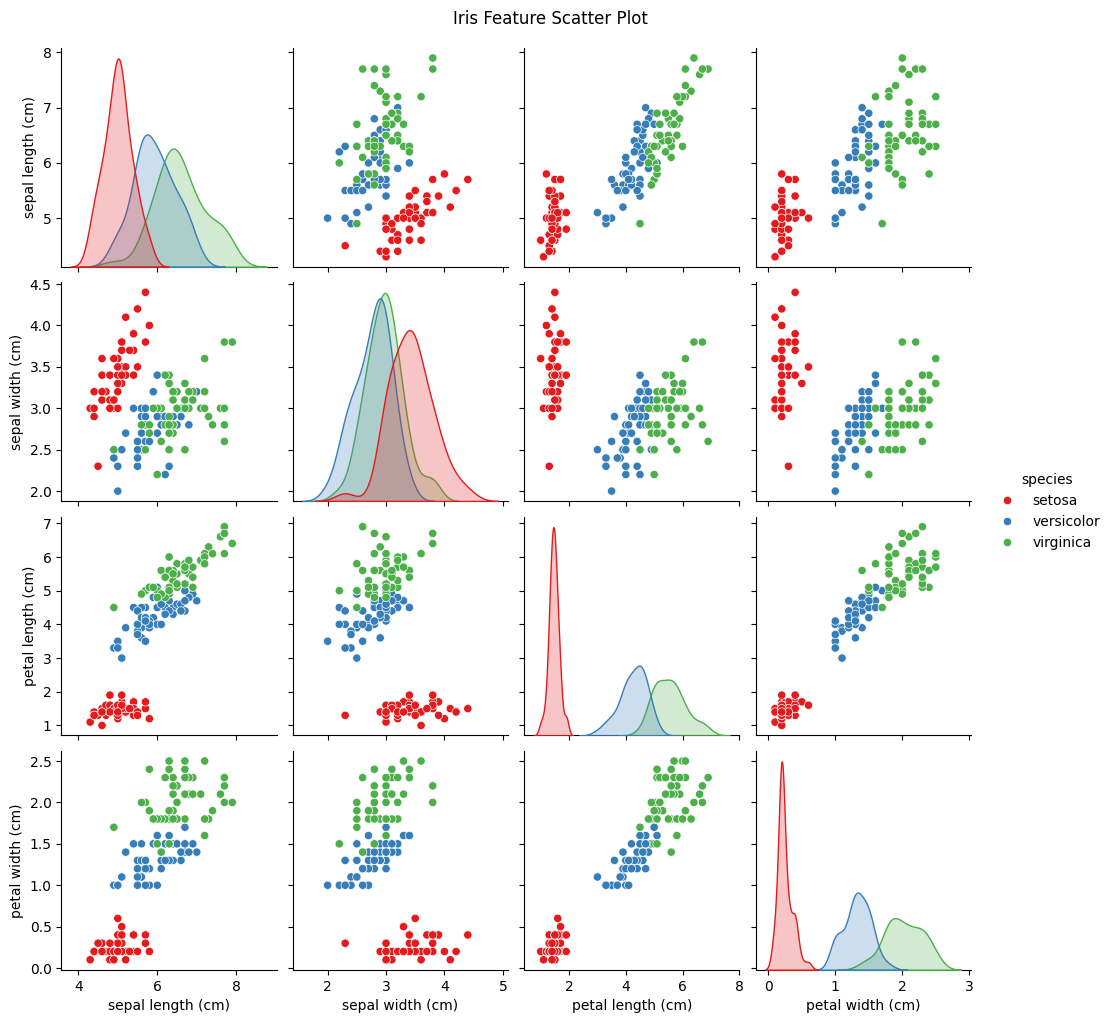

In [59]:
df = pd.DataFrame(X, columns=feature_names)
df['species'] = [species_names[i] for i in Y]

sns.pairplot(df, hue='species', palette='Set1')
plt.suptitle("Iris Feature Scatter Plot", y=1.02)
plt.show()

**What can we observe from the scatter plot?**

- 🌸 *Iris Setosa* is **linearly seperable**. It is very easy to see how comfortable it is to draw a straight line that separates this species from the rest

- In the case of 🌿*Iris Versicolor* and 🍀*Iris Virginica*, both species tend to **overlap** one another, they can't be linearly separated and it makes the classification a lot harder

Therefore - 🌸 *Iris Setosa* is the flower species that seems to be the most separable out of all flower species.

## 🔹 **Splitting the Data**

Before training the **Multiclass SVM** we need to **split the dataset** into training, validation and test sets. This will **ensure that our model is trained properly, validated for hyperparameter tuning and evaluated on unseen data**.

We will split 60% of the total dataset to the **training set**, 20% to the **validation set** and 20% to the **test set**. We use the `train_test_split()` to do so. We also use `stratify` parameter because the **Iris dataset** is relatively small, using `stratify` will be able to ensure that the **class distribution remains balanced across all sets**.  

In [60]:
# Split 80% for train + val and 20 % for test
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)

# Split 60 % for train and 20 % for validation
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.25, random_state = 42)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 90
Validation set size: 30
Test set size: 30


As we can tell, the sizes of the sets indicate that the sets are split correctly.

## 🔹**Training Multiclass SVM with SMO**

Here we introduce the function `train_multiclass_svm()` that is responsible for the **training of multiple binary SVM classifiers** using the **OvA** approach. Now, since standard **SVMs are binary classifiers**, the idea would be to train **one classifier per class**, where each classifier distinguishes one class from the rest

In [61]:
def train_multiclass_svm(X_train, Y_train, C, ker_func, tolerance, eps, max_iter, gamma=None):
 classifiers = {}
 unique_labels = np.unique(Y_train)
 for label in unique_labels: # loop over each class
  with tqdm(total=1, desc=f"training class {label}") as pbar: # implemented to use label in desc
   # Create binary labels: +1 for current class, -1 for others.
   Y_binary = np.where(Y_train == label, 1, -1)
   alphas, b = train_SMO(X_train, Y_binary, C, ker_func, tolerance, eps, max_iter, gamma) # Core process: the training of the SVM based on the SMO algorithm
   classifiers[label] = (alphas, b, Y_binary, X_train) # We will store the trained SVM in a dictionary with class labels as keys

   pbar.update(1) #update progress bar

 return classifiers

The key player here is the `y_binary` variable, it converts the **multi-class problem** into a **binary classification problem**.

##🔹**Making Predictions**



Now when we have trained multiple **binary SVM classifiers**, we need a function **to predict the class of new test samples**.

The function `predict_multiclass()` will do exactly that - it will take the trained classifiers and will assign the most probable class to each test sample, by picking the class with **the highest confidence score chosen as predicted label**


In [62]:
def predict_multiclass(X_test, classifiers, ker_func, gamma=None):
 predictions = []
 for x in tqdm(X_test, desc="Predicting samples", unit="sample"): # loop over each sample in the test set
  scores = {}
  for label, (alphas, b, Y_binary, X_train) in classifiers.items():
    # Compute kernel between x and all training samples.
    if ker_func == linear_ker:
      K = np.dot(X_train, x)

    elif ker_func == rbf_ker:
      X_train_norm = np.sum(X_train**2, axis=1)
      x_norm = np.sum(x**2)
      K = np.exp(-gamma * (X_train_norm + x_norm - 2 * np.dot(X_train, x)))

    else:
      K = np.array([ker_func(x_tr, x) for x_tr in X_train])

    f_x = np.sum(alphas * Y_binary * K) + b # Computation of the decision function value
    scores[label] = f_x

  # Select class with highest decision function score
  pred_label = max(scores, key=scores.get)
  predictions.append(pred_label)


 return np.array(predictions) # return predictions only after all samples are classified

## 🔹 **Hyperparameter Tuning on Validation Set (Linear Kernel)**

Once we have trained our **multiclass SVM classifiers**, we would need to **tune the hyperparameter** $C$ to find the best value for our model. By using the **validation set**, we can provide an unbiased evaluation for the training stage and tune this hyperparameter.

As mentioned in the Maman, it is a useful set. It can be used to **avoid overfitting** to the training set, by **stopping the training** when the error on the validation set increases and it can improve the accuracy.

In order to do so, we will have to make a helper function `compute_accuracy()` to get the **accuracy** of each $C$ values. It plays a crucial role because in the end, we choose the best $C$ value based on the highest validation accuracy  

In [63]:
def compute_accuracy(cm):
 return np.sum(np.diag(cm)) / np.sum(cm) # Calculate diagonal elements and divide by the total samples

Now we can choose the best $C$ value.
We explicitly chose a range of $[0.01, 0.1 , 1, 10, 100]$ values to cover a wide range of model behaviors. We have chosen values that are small to allow **larger margins** (to tolerate misclassifications) and we have also chosen values that are large, which will force the model to minimize misclassification errors, but at a cost of a **narrow margin** (which can be a potential for overfitting). This range is wide enough to be able to efficiently pick the best $C$.

The way we explore the best $C$ is straightforward - we explore each $C$ value and use the **Linear kernel function** to train the model. We then predict with the validation set and set the accuracies accordingly

In [64]:
C_values = [0.01, 0.1 , 1, 10, 100]
best_C_linear = None
best_accuracy_linear = 0

for C in C_values:
  classifiers_linear = train_multiclass_svm(X_train, Y_train, C, linear_ker, tolerance= 0.001, eps=0.00001, max_iter=5000 )
  Y_val_linear_pred = predict_multiclass(X_val, classifiers_linear, linear_ker)
  cm_val = confusion_matrix(Y_val, Y_val_linear_pred)
  accuracy_val = compute_accuracy(cm_val)

  if accuracy_val > best_accuracy_linear: #Checking for best accuracy values
    best_accuracy_linear = accuracy_val
    best_C_linear = C


training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

Now when we have determined the best $C$ value using the validation accuracy, we can **retrain** the **multiclass SVM** on the **full training set**

In [65]:
final_linear_classifiers = train_multiclass_svm(X_train, Y_train, best_C_linear, linear_ker, tolerance=0.001, eps=0.00001, max_iter=5000)

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

After training, we can use this best $C$ value to **predict labels** for the **test set**:

In [66]:
y_pred_linear = predict_multiclass(X_test, final_linear_classifiers, linear_ker)

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

## 🔹**Evaluating the Model Performance (Linear Kernel)**

After training and testing our **multi class SVM** model, We will assess the model's performance based on what we've mentioned in the *Key Considerations for our Multiclass SVM* part:

### 📌 1️⃣**Confusion Matrix**

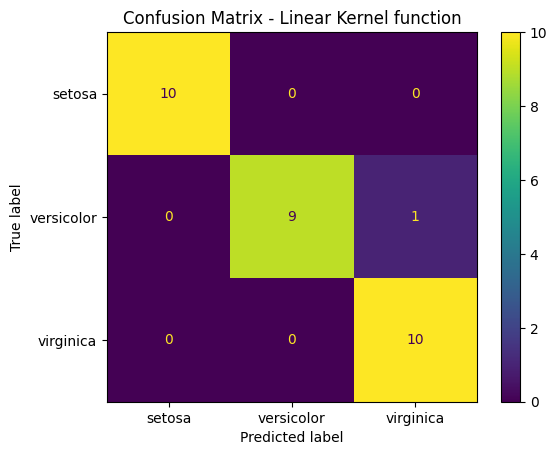

Accuracy: 0.9667


In [67]:
cm_linear = confusion_matrix(Y_test, y_pred_linear) #Compute confusion matrix
accuracy = compute_accuracy(cm_linear) #Compute the accuracy based on the final confusion matrix

#Display confusion matrix + accuracy
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_linear, display_labels=[species_names[0],species_names[1],species_names[2]])
cm_display.plot(cmap="viridis")
plt.title("Confusion Matrix - Linear Kernel function")
plt.show()
print(f"Accuracy: {accuracy:.4f}")

###📌2️⃣ **Table of Confusion and Sensitivities for each class**

Calculating tables of confusion for each class:   0%|          | 0/3 [00:00<?, ?it/s]

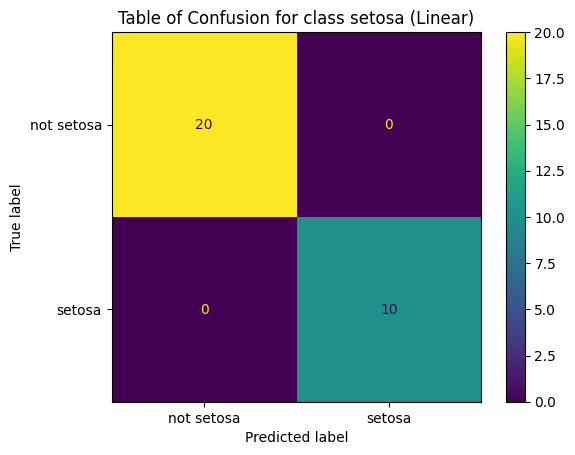

Sensitivity for class setosa: 1.0


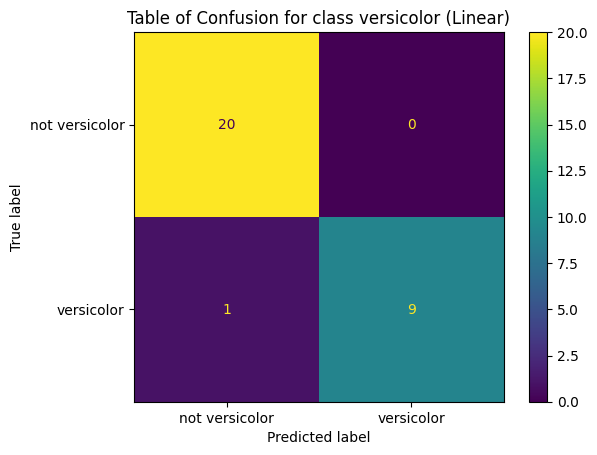

Sensitivity for class versicolor: 0.9


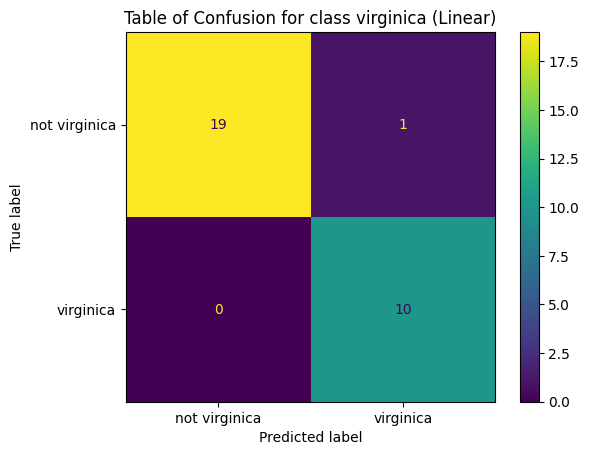

Sensitivity for class virginica: 1.0


In [68]:
for i in tqdm(range(3), desc='Calculating tables of confusion for each class'):
  # Converting to binary labels
  y_test_bin = (Y_test == i).astype(int)
  y_pred_bin = (y_pred_linear == i).astype(int)

  cm_class = confusion_matrix(y_test_bin, y_pred_bin) #Compute binary confusion matrix
  cm_class_display = ConfusionMatrixDisplay(confusion_matrix = cm_class, display_labels = [f"not {species_names[i]}", species_names[i]])
  cm_class_display.plot()
  plt.title(f"Table of Confusion for class {species_names[i]} (Linear)")
  plt.show()

  # Compute TP,TN,FP,FN values
  TP = cm_class[1,1] if cm_class.shape[0] > 1 else 0
  FN = cm_class[1,0] if cm_class.shape[0] > 1 else 0
  FP = cm_class[0,1] if cm_class.shape[0] > 1 else 0
  TN = cm_class[0,0] if cm_class.shape[0] > 1 else 0

  # Sensitivity
  sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
  print(f"Sensitivity for class {species_names[i]}: {sensitivity}")


##🔹**Discussion of Results: Linear Kernel on the Iris Dataset**

After doing all the necessary training and evaluation of the multiclass SVM, using **linear kernel**, we may discuss the results and makes insights about its strengths and weaknesses.

**Looking at the overall accuracy**, the model has shown a **high accuracy score of 0.9667**. It indicates that the linear kernel **captures most of the linear relationships** between the features in the classification process.
What we can also observe is that Both **🌸 Iris Setosa** and **🍀Iris Verginica** have a maximum score of 1 on the sensitivity metric, whereas 🌿**Iris versicolor** has a sensitivity of 0.9. We can easily observe that in the 🌿**Iris versicolor** class, the model managed to correctly classify **9 out of 10 versicolor samples**. This indicates that the model was **effective** in identifying samples that belong to this class. Same can be said about all the other classes.

What are the observed **strengths of the model**?

- It has **high sensitivity across all the classes**, which means that in the majority of cases, the model can identify true samples of these classes.

- Using a simple linear kernel makes it **very attractive** because it can be easily computed and yet derive very good results over all classes.


However, it is still important to note that **the model is not perfect**. We can Identify that there was a misclassification between versicolor and virginica, which might indicate that there is some overlap between these two classes that the model struggles with.

In addition, we know that the **linear kernel** can't handle complex and non-linear decision boundaries. Although the model performed well on the Iris dataset, this dataset is relatively simplistic, the linear kernel might struggle with more complex datasets.

## 🔹 **Hyperparameter Tuning on Validation Set (RBF Kernel)**

Now we will repeat the training and evaluation process but using the **RBF Kernel**. We will start by tuning the hyperparameters $C$ and $\gamma$. The goal would be to find an optimal pair of $C$ and $\gamma$ that will maximize the model's accuracy on the validation set.

Just like in the **linear kernel**, we will keep the same range of possible $C$ values, and introduce a new range of possible values for $\gamma$. We chose the range of $\gamma$ values to be in $[0.01,0.1,1,10]$.

As we know, the $\gamma$ variable defines **the influence of individual training samples on the decision boundary**. If we will take a **small** $\gamma$ value, it would mean that there is **a greater influence**, while picking a **larger** $\gamma$ value would means that there would be **a smaller influence**. Using the range we introduced would be beneficial since the range is wide enough to be able to efficiently pick the best $\gamma$ value

In [74]:
C_values = [0.01, 0.1 , 1, 10, 100]
gamma_values = [0.01, 0.1, 1, 10]
best_C_rbf = None
best_gamma_rbf = None
best_accuracy_rbf = 0

for C in C_values:
  for gamma in gamma_values:
    classifiers_rbf = train_multiclass_svm(X_train, Y_train, C, rbf_ker, tolerance= 0.001, eps=0.00001, max_iter=5000, gamma=gamma)
    Y_val_rbf_pred = predict_multiclass(X_val, classifiers_rbf, rbf_ker, gamma=gamma)
    cm_val_rbf = confusion_matrix(Y_val, Y_val_rbf_pred)
    accuracy_val = compute_accuracy(cm_val_rbf)
    if accuracy_val > best_accuracy_rbf:
      best_accuracy_rbf = accuracy_val
      best_C_rbf = C
      best_gamma_rbf = gamma

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

Now, when we have determined the best $C$ and $\gamma$  values using the **validation accuracy**, we can retrain the **multiclass SVM** on the full training set:


After training, we can use this best C value to predict labels for the test set:


In [75]:
final_classifiers_rbf = train_multiclass_svm(X_train, Y_train, best_C_rbf, rbf_ker, tolerance=0.001, eps=0.00001, max_iter=5000, gamma=best_gamma_rbf)

training class 0:   0%|          | 0/1 [00:00<?, ?it/s]

training class 1:   0%|          | 0/1 [00:00<?, ?it/s]

training class 2:   0%|          | 0/1 [00:00<?, ?it/s]

After training, we can use these values to predict labels for the test set:

In [76]:
y_pred_rbf = predict_multiclass(X_test, final_classifiers_rbf, rbf_ker, gamma=best_gamma_rbf)

Predicting samples:   0%|          | 0/30 [00:00<?, ?sample/s]

##**🔹Evaluating the Model Performance (RBF Kernel)**

After training and testing our multi class SVM model, We will assess the model's performance based on what we've mentioned in the Key Considerations for our Multiclass SVM part:

### 📌1️⃣ **Confusion Matrix**

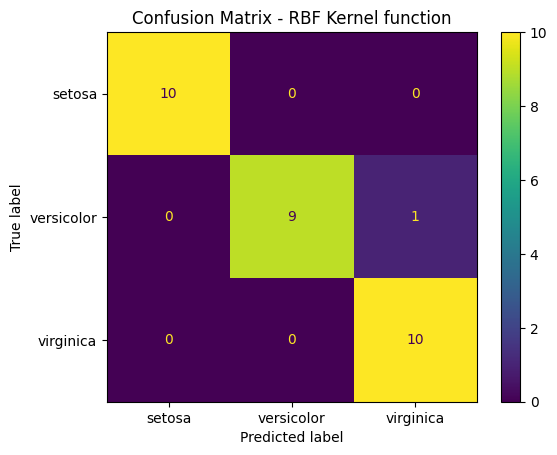

Accuracy: 0.9667


In [77]:
cm_rbf = confusion_matrix(Y_test, y_pred_rbf) #Compute confusion matrix
accuracy = compute_accuracy(cm_rbf) #Compute the accuracy based on the final confusion matrix

#Display confusion matrix + accuracy
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_rbf, display_labels=[species_names[0],species_names[1],species_names[2]])
cm_display.plot(cmap="viridis")
plt.title("Confusion Matrix - RBF Kernel function")
plt.show()
print(f"Accuracy: {accuracy:.4f}")

###📌2️⃣ **Table of Confusion and Sensitivity for each class**

Calculating tables of confusion for each class:   0%|          | 0/3 [00:00<?, ?it/s]

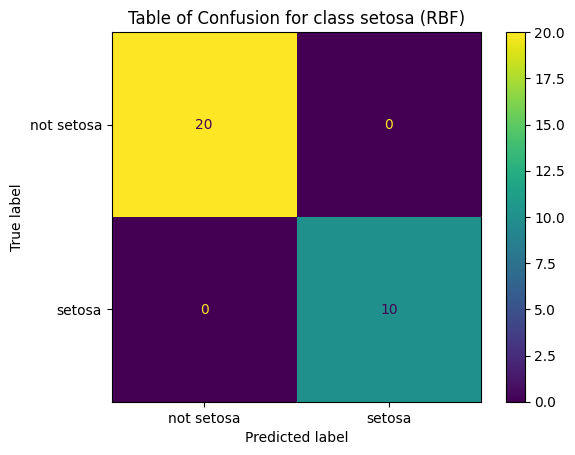

Sensitivity for class setosa: 1.0


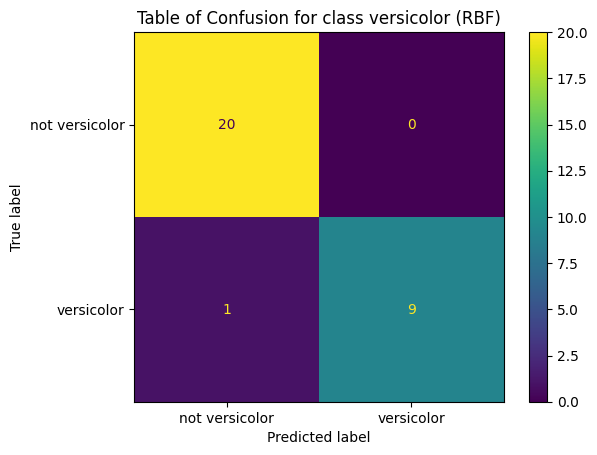

Sensitivity for class versicolor: 0.9


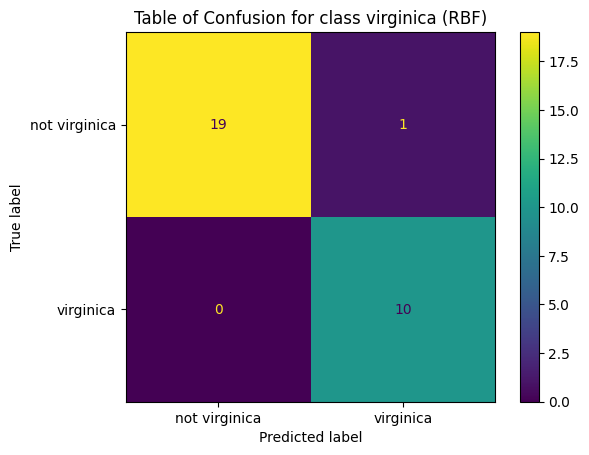

Sensitivity for class virginica: 1.0


In [73]:
for i in tqdm(range(3), desc='Calculating tables of confusion for each class'):
  # Converting to binary labels
  y_test_bin = (Y_test == i).astype(int)
  y_pred_bin = (y_pred_linear == i).astype(int)

  cm_class = confusion_matrix(y_test_bin, y_pred_bin) #Compute binary confusion matrix
  cm_class_display = ConfusionMatrixDisplay(confusion_matrix = cm_class, display_labels = [f"not {species_names[i]}", species_names[i]])
  cm_class_display.plot()
  plt.title(f"Table of Confusion for class {species_names[i]} (RBF)")
  plt.show()

  # Compute TP,TN,FP,FN values
  TP = cm_class[1,1] if cm_class.shape[0] > 1 else 0
  FN = cm_class[1,0] if cm_class.shape[0] > 1 else 0
  FP = cm_class[0,1] if cm_class.shape[0] > 1 else 0
  TN = cm_class[0,0] if cm_class.shape[0] > 1 else 0

  # Sensitivity
  sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
  print(f"Sensitivity for class {species_names[i]}: {sensitivity}")



##🔹**Results Comparison between Linear Kernel and RBF Kernel**

Let us compare the performance of the **Linear SVM** and **RBF SVM** on the **Iris dataset**:

**Accuracy Results:**

| Kernel Type  | Accuracy (%)|
|-------------|------------|
| **Linear Kernel** | 96.67%|
| **RBF Kernel** | 96.67%|


| Actual\Predicted  | Set|
|-------------|------------|
| **Linear Kernel** | 96.67%|
| **RBF Kernel** | 96.67%|


**Confusion Matrix of Linear Kernel**:

| Actual \ Predicted | Setosa | Versicolor | Virginica |
|-------------------|--------|------------|-----------|
| **Setosa**       | 10     | 0          | 0         |
| **Versicolor**    | 0      | 9          | 1         |
| **Virginica**     | 0      | 0          | 10        |

**Confusion Matrix of RBF Kernel**:

| Actual \ Predicted | Setosa | Versicolor | Virginica |
|-------------------|--------|------------|-----------|
| **Setosa**       | 10     | 0          | 0         |
| **Versicolor**    | 0      | 9          | 1         |
| **Virginica**     | 0      | 0          | 10        |

---


From the confusion matrices, both models **misclassified only one versicolor sample for a virginica**, which lead to an identical **overall accuracy of 0.9667**.

What we can imply from this is that there is no significant difference in performance between those two models, both achieve high performance and successfully classified the majority of classes. One key observation that we see here is that the **Setosa** species, the one that we thought of to be the species that is linearly separable from all the rest (by looking at the scatter plot), is in fact always correctly classified (It always reaches perfect sensitivity of 1 in both kernels), and therefore truly is linearly separable (from an observation).

In terms of the **RBF Kernel performance**, we could say that in theory, the **RBF** can capture non-linear decision boundaries better than **Linear Kernel**, but the **Iris dataset** doesn't require high non-linear decision boundaries, and since there are 2 other species that overlap each other, **RBF** doesn't significantly outperforms the linear kernel.

**What can we conclude from the findings?**

Since **Both of the models achieved the same accuracy**, The **Linear Kernel** is preferable, simply because it is a lot simpler and a lot faster than **RBF Kernel**. If we were to work with other datasets, that can have more overlapping or complex decision boundaries, the **RBF Kernel** might've had an advantage over the **Linear Kernel**, but as for the **Iris Dataset**, the linear kernel is good enough.